In [53]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from astropy.io import ascii
import scipy
import wandb
import os

In [54]:
all_dr25 = pd.read_csv("result.csv")
selected_stars = all_dr25.where((all_dr25["log(g)"]>4)&(all_dr25["Mass"]<1.2)&(all_dr25["Mass"]>0.8)).dropna(how='all')

data = ascii.read("nph-nstedAPI.txt")  
all_stars = data.to_pandas()
all_stars_in_selected_stars = all_stars[all_stars['kepid'].isin(selected_stars["KIC"])]
all_stars_in_selected_stars = all_stars_in_selected_stars[~np.isnan(all_stars_in_selected_stars["rrmscdpp06p0"])]


In [55]:
import glob

x = torch.zeros((0,7))
y = torch.zeros((0,11))

for i in glob.glob("simulations_etazero/data_x*"):
    run_label = i[34:]
    xnew = torch.load(i)
    ynew = torch.load("simulations_etazero/data_y_mult_hist_"+run_label)
    x = torch.concatenate((x,xnew),dim=0)
    y = torch.concatenate((y,ynew),dim=0)


#torch.save(x,"all_sims_x")
#torch.save(y,"all_sims_y")

print(x.shape)
valid_indices = torch.where(torch.sum(y,dim=1)>=108013)
invalid_indices = torch.where(torch.sum(y,dim=1)<108013)

x_invalid = x[invalid_indices]

x = x[valid_indices]
y = y[valid_indices]

print(x.shape)

torch.Size([3742, 7])
torch.Size([1281, 7])


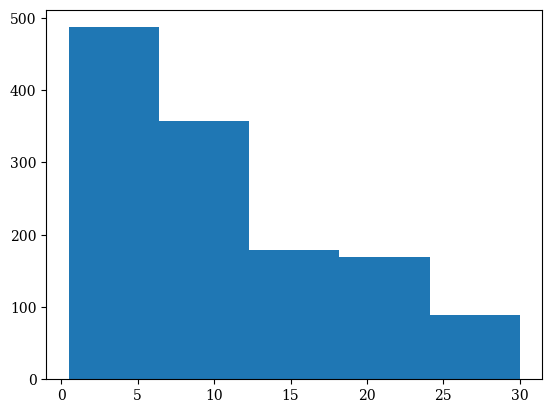

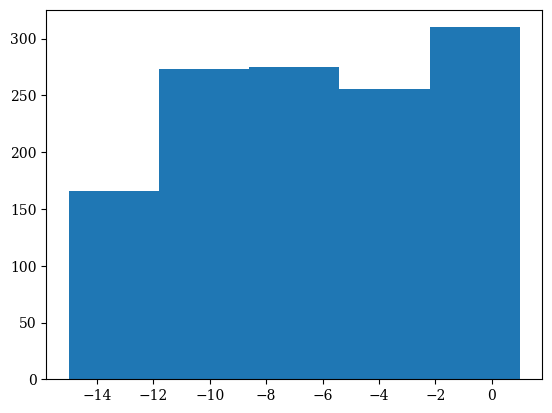

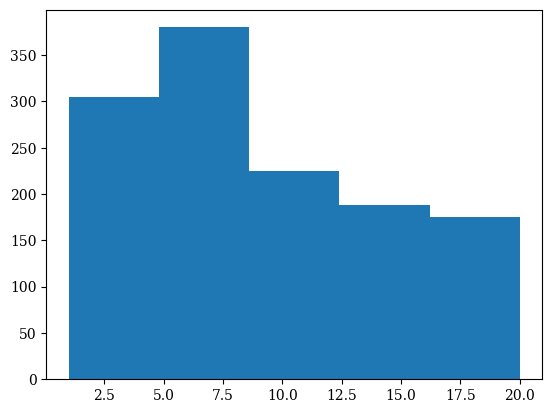

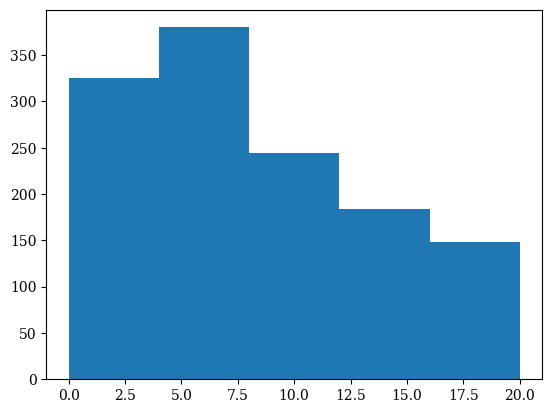

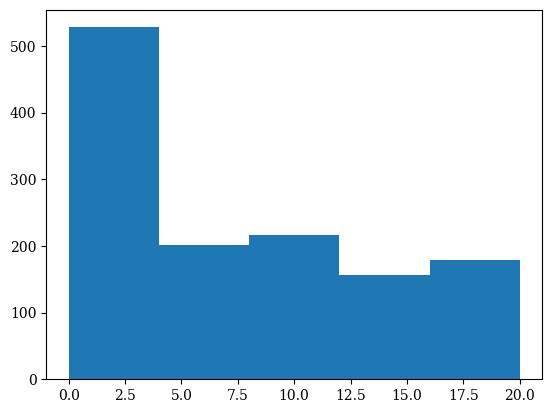

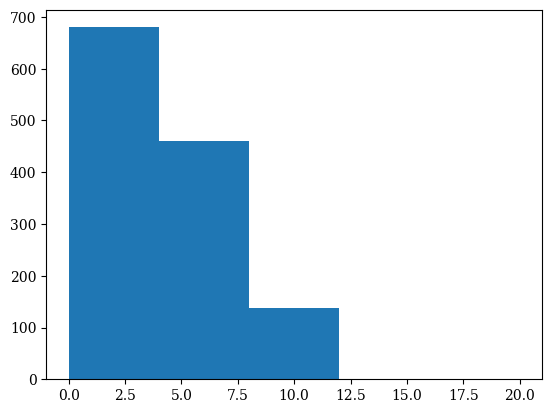

In [56]:
ranges = np.array([[.5,30],[-15,0.999],[1.0001,20],[0.01,20],[0.01,20],[0.01,20],[0,1]])

for i in range(6):
    plt.figure()
    #plt.plot(torch.unique(x[:,i]),"x")
    plt.hist(x[:,i],bins=5, range=ranges[i])

In [57]:
observation, _ = np.histogram(all_stars_in_selected_stars["nconfp"],bins = range(0,12))
N = np.sum(observation)
observation = torch.Tensor(observation)
#y = torch.load("sims/data_y_mult_hist_fixstars_all")/N
#x = torch.load("sims/data_x_params_fixstars_all")
#y = y/N

shuffle_mask = torch.randperm(x.size()[0])
x=x[shuffle_mask]
y=y[shuffle_mask]

torch.sum(y[0],dim=0)

tensor(108014.)

In [58]:

class Emulator(nn.Module):
    def __init__(self):
        super(Emulator, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(6, 64)     
        self.fc2 = nn.Linear(64, 128)  
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)   
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 11)
                             
        # Activation function
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.log_softmax = nn.LogSoftmax()

    def forward(self, x):
        
        x = self.relu(self.fc1(x))      
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)      
        x = self.relu(self.fc3(x) )
        x = self.dropout(x)
        x = self.relu(self.fc4(x) )
        x = self.dropout(x)
        x = self.relu(self.fc5(x) )
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.log_softmax(self.fc7(x))        
        
        # logits_10 = self.fc7(x)  # 10 logits from the network
        # logit_0 = -torch.exp(torch.logsumexp(logits_10,1,keepdim=True))
    
        # logits_all = torch.cat([logit_0, logits_10], dim=-1)  # Concatenate with the 11th bin
        # log_probs = torch.log_softmax(logits_all, dim=-1)

        return x



model = Emulator()

learning_rate = 0.0005
num_epochs = 5000
batch_size = 16
train_percent = 0.8
train_size = int(len(x)*train_percent)
step_size = 1000

# Loss and optimizer
#criterion = nn.KLDivLoss(reduction="batchmean",log_target=True)  # Change this if it's a classification problem
#criterion = nn.L1Loss()

def criterion(output,target):
    return -torch.sum((target*output),dim=1)
    
# L2 loss, no softmax

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,step_size)

norm_factor = (torch.max(x,dim=0)[0])

inputs = x[:train_size,:-1]/norm_factor[:-1]
targets = y[:train_size]
#targets = torch.log(torch.clamp(targets,min = 1/(N*np.e)))

inputs_val = x[train_size:,:-1]/norm_factor[:-1]
targets_val = y[train_size:]
#targets_val = torch.log(torch.clamp(targets_val,min = 1/(N*np.e)))

dataset = torch.utils.data.TensorDataset(inputs, targets)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset_val = torch.utils.data.TensorDataset(inputs_val, targets_val)
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)




In [49]:
training_index = f"batch_size_{batch_size}_lr_{learning_rate}_datasize_{x.shape[0]}"

os.environ["WANDB_NOTEBOOK_NAME"] = "planet-sim-emulator.ipynb"

wandb.init(
    project="kepler pop",  
    name=training_index,         
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "datasize": x.shape[0],
        "scheduler_step_size": step_size,
        "train_percentage": train_percent}
)


In [50]:
train_losses = []
val_losses = []
min_val_loss = 10000000


# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for batch_inputs, batch_targets in data_loader:
        # Forward pass
        outputs = model(batch_inputs)
            
        loss = torch.mean(criterion(outputs, batch_targets),dim=0)
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        
        loss.backward()        # Backpropagation
 
        optimizer.step()       # Update weights
 
        running_loss  += loss.item()
        scheduler.step()

    running_loss_val  = 0.0

    with torch.no_grad():
        model.eval()
        for batch_inputs, batch_targets in data_loader_val:
            
            outputs = model(batch_inputs)
            loss = torch.mean(criterion(outputs, batch_targets),dim=0)
            running_loss_val  += loss.item()


    train_losses.append(running_loss / len(data_loader))
    val_losses.append(running_loss_val / len(data_loader_val))

    wandb.log({"train": {"loss":np.average(np.array(train_losses))}, "val": {"loss": np.average(np.array(val_losses))}})

    if running_loss_val / len(data_loader_val) < min_val_loss :
        min_val_loss  = running_loss_val / len(data_loader_val)
        best_model  = model
        torch.save(best_model .state_dict(), "best_model_0to10")
    # Print loss for each epoch
    
    avg_loss = running_loss  / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs }], Loss: {avg_loss:.4f}")


print("Training complete!")
wandb.finish()

Epoch [1/5000], Loss: 102761.9680
Epoch [2/5000], Loss: 32876.0931
Epoch [3/5000], Loss: 29641.0404
Epoch [4/5000], Loss: 28897.1262
Epoch [5/5000], Loss: 28240.2452
Epoch [6/5000], Loss: 28234.7746
Epoch [7/5000], Loss: 27667.1704
Epoch [8/5000], Loss: 27531.7629
Epoch [9/5000], Loss: 27521.7665
Epoch [10/5000], Loss: 27556.2035
Epoch [11/5000], Loss: 27255.8607
Epoch [12/5000], Loss: 27307.9584
Epoch [13/5000], Loss: 27346.7642
Epoch [14/5000], Loss: 27363.1497
Epoch [15/5000], Loss: 27346.4361
Epoch [16/5000], Loss: 27206.7771
Epoch [17/5000], Loss: 27364.5089
Epoch [18/5000], Loss: 27189.6857
Epoch [19/5000], Loss: 27096.2799
Epoch [20/5000], Loss: 27234.4515
Epoch [21/5000], Loss: 27055.0531
Epoch [22/5000], Loss: 27195.2059
Epoch [23/5000], Loss: 27135.9306
Epoch [24/5000], Loss: 26975.2684
Epoch [25/5000], Loss: 26916.6611
Epoch [26/5000], Loss: 26939.1813
Epoch [27/5000], Loss: 26809.9187
Epoch [28/5000], Loss: 26836.9999
Epoch [29/5000], Loss: 26657.0131
Epoch [30/5000], Loss:

In [47]:
wandb.finish()

Text(0.5, 0, 'epoch')

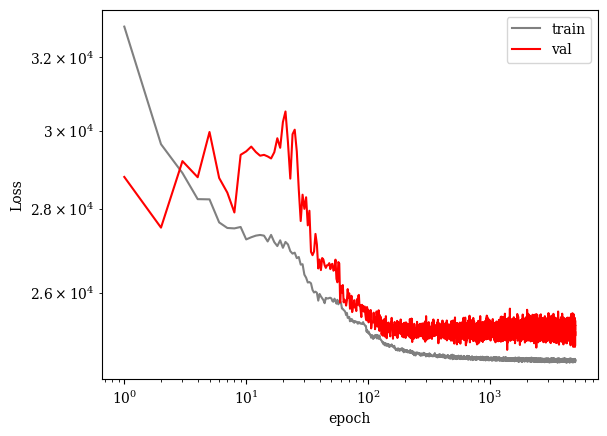

In [51]:

plt.figure()

plt.loglog(range(1,num_epochs),train_losses[1:],color="gray",label="train")
plt.loglog(range(1,num_epochs),val_losses[1:],color="red",label="val")

plt.legend()
plt.ylabel("Loss")
plt.xlabel("epoch")


C:\Users\vtard\AppData\Local\Temp\ipykernel_19512\1471562549.py:34: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i].set_ylim(bottom=-1/np.log(10)-0.5,top=500000)


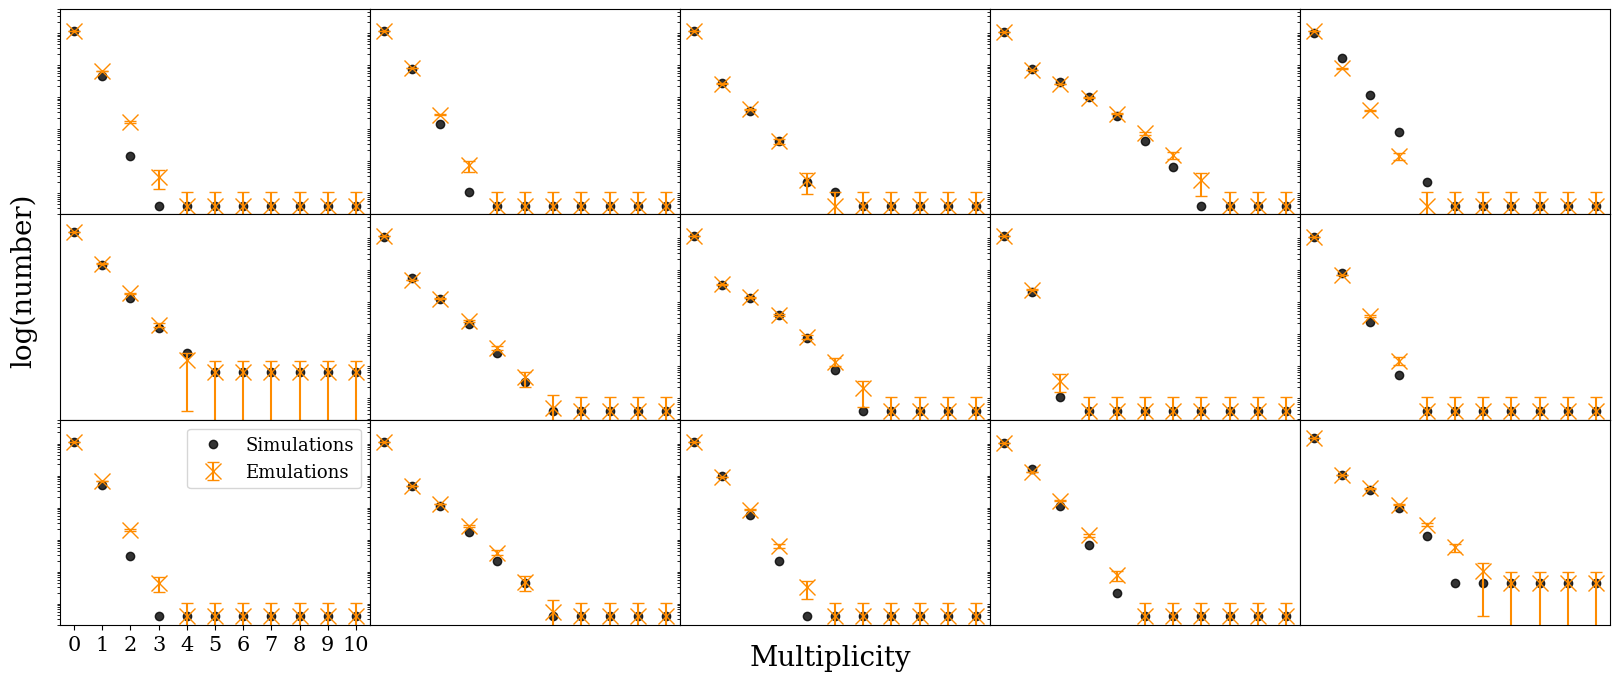

In [52]:
from matplotlib import rcParams

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{cmunitx}'  # Load CMU fonts

model.eval()
model.load_state_dict(torch.load("best_model_0to10", weights_only=True))

#emulated_nozeros = model(inputs_val)
#logr0 = -torch.exp(torch.logsumexp(emulated_nozeros,1,keepdim=False)).detach().numpy()
#emulated_nozeros = emulated_nozeros.detach().numpy()
#emulated = np.exp(np.concatenate((logr0[:, np.newaxis], emulated_nozeros), axis=1))*N
simulated = targets_val
simulated[simulated==0.0] = 1/(np.e)
emulated = np.exp(model(inputs_val).detach().numpy())*N
emulated[emulated<1/(np.e)] = 1/(np.e)
error_em = emulated**0.5
x_params = inputs_val

# Create a 4x5 subplot figure
fig, axs = plt.subplots(3, 5, figsize=(20, 8), sharex=False, sharey=False)

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Iterate through the first 20 sets and plot
for i in range(15):
    # Plot the semilogy plot for simulated and emulated data
    
    axs[i].semilogy(range(0, 11), simulated[i], "o",  markersize = 6,color="black",alpha=0.8,label="Simulations")
    axs[i].errorbar(range(0, 11), emulated[i], yerr = error_em[i],capsize=4,fmt="x", markersize = 12,color="darkorange",label="Emulations")

    axs[i].set_ylim(bottom=-1/np.log(10)-0.5,top=500000)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #axs[i].text(5, 200, x_params[i,:]*(torch.max(x,dim=0)[0]).numpy(), fontsize=6, ha='center', va='center')
     
axs[-5].legend(loc="upper right",fontsize=13)
plt.subplots_adjust(wspace=0, hspace=0)
axs[-5].set_xticks(range(0,11),range(0,11),fontsize=15)
#axs[-5].set_yticks([0,2,4],[0,2,4],fontsize=15)
fig.text(0.47,0.06,'Multiplicity',fontsize=20)
fig.text(0.1,0.44,'log(number)',fontsize=20,rotation="vertical")
plt.savefig("sim_vs_em.png")


c:\Users\vtard\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Text(0.1, 0.44, 'log(number)')

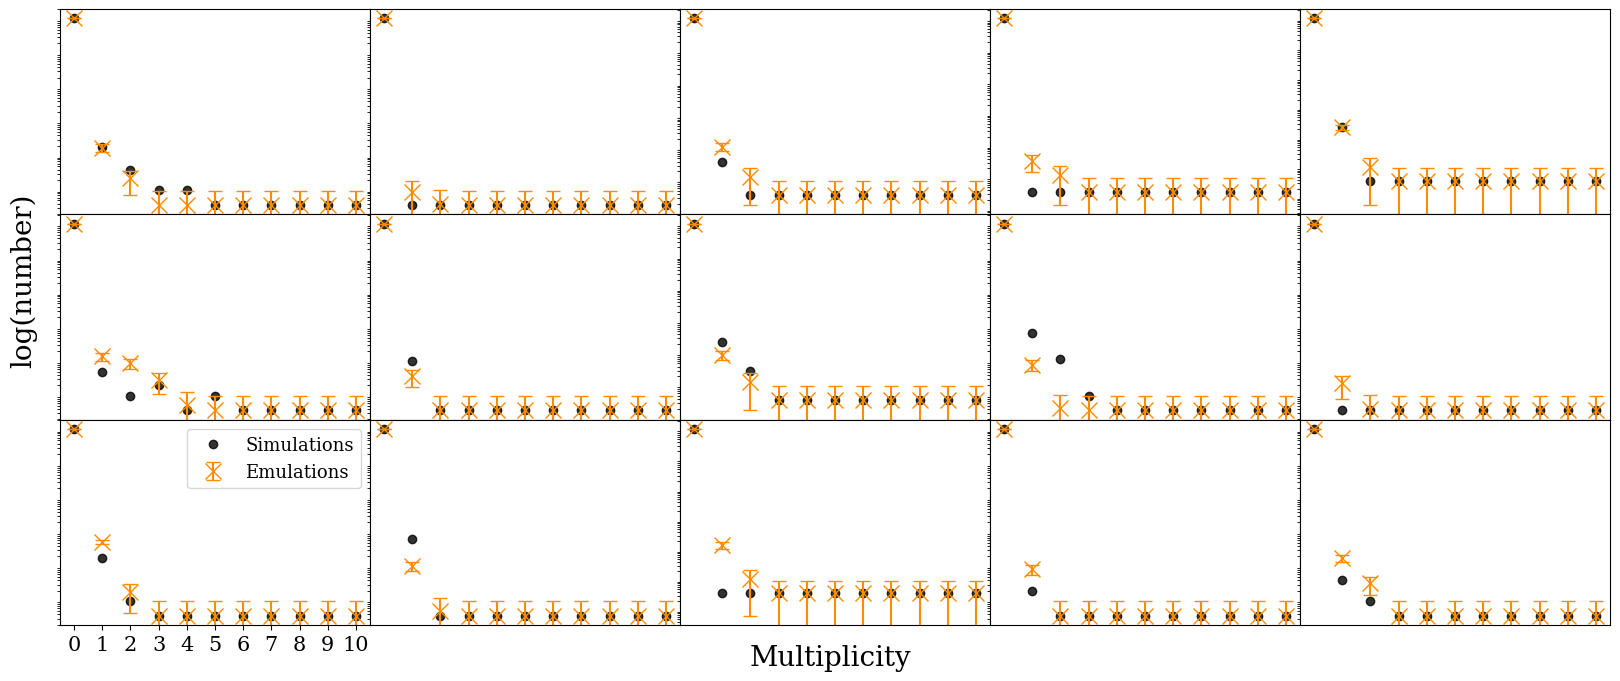

In [60]:
from matplotlib import rcParams

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{cmunitx}'  # Load CMU fonts

model.eval()
model.load_state_dict(torch.load("best_model_0to10", weights_only=True))

#emulated_nozeros = model(inputs_val)
#logr0 = -torch.exp(torch.logsumexp(emulated_nozeros,1,keepdim=False)).detach().numpy()
#emulated_nozeros = emulated_nozeros.detach().numpy()
#emulated = np.exp(np.concatenate((logr0[:, np.newaxis], emulated_nozeros), axis=1))*N
simulated = y[x[:,-1] >0.95]
simulated[simulated==0.0] = 1/(np.e)
emulated = np.exp(model(x[x[:,-1] >0.95]/(torch.max(x,dim=0)[0])).detach().numpy())*N
emulated[emulated<1/(np.e)] = 1/(np.e)
error_em = emulated**0.5

# Create a 4x5 subplot figure
fig, axs = plt.subplots(3, 5, figsize=(20, 8), sharex=False, sharey=False)

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Iterate through the first 20 sets and plot
for i in range(15):
    # Plot the semilogy plot for simulated and emulated data
    
    axs[i].semilogy(range(0, 11), simulated[i], "o",  markersize = 6,color="black",alpha=0.8,label="Simulations")
    axs[i].errorbar(range(0, 11), emulated[i], yerr = error_em[i],capsize=5,fmt="x", markersize = 12,color="darkorange",label="Emulations")

    #axs[i].set_ylim(bottom=-1/np.log(10)-0.5,top=5.4)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
     
axs[-5].legend(loc="upper right",fontsize=13)
plt.subplots_adjust(wspace=0, hspace=0)
axs[-5].set_xticks(range(0,11),range(0,11),fontsize=15)
#axs[-5].set_yticks([0,2,4],[0,2,4],fontsize=15)
fig.text(0.47,0.06,'Multiplicity',fontsize=20)
fig.text(0.1,0.44,'log(number)',fontsize=20,rotation="vertical")
#plt.savefig("sim_vs_em.png")

In [333]:
import os
import re

# Define the folder where your files are
folder_path = "simulations"  # <- Change this

# Pattern to extract values (e.g. r0.5_as-1_ab1.1_s0.1_si0.1_bm12_ez0.01)
pattern = re.compile(r"data_x_params_r(?P<r>[-\d.]+)_as(?P<as>[-\d.]+)_ab(?P<ab>[-\d.]+)_s(?P<s>[-\d.]+)_si(?P<si>[-\d.]+)_bm(?P<bm>[-\d.]+)_ez(?P<ez>[-\d.]+)")

rcrits = []
alpha_smalls = []
alpha_bigs = []
sigmas = []
sigma_is = []
b_ms =  []
eta_zeros = []

# Loop through files and extract variables
for filename in os.listdir(folder_path):
    match = pattern.match(filename)
    if match:
        variables = {key: float(val) for key, val in match.groupdict().items()}
        rcrits.append(variables["r"])
        alpha_smalls.append(variables["as"])
        alpha_bigs.append(variables["ab"])
        sigmas.append(variables["s"])
        sigma_is.append(variables["si"])
        b_ms.append(variables["bm"])
        eta_zeros.append(variables["ez"])
        




<ErrorbarContainer object of 3 artists>

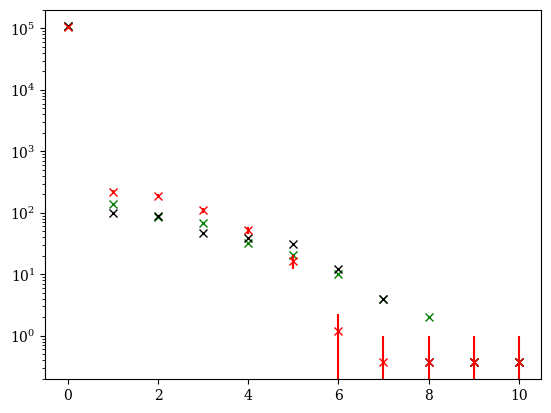

In [125]:
x2 = torch.zeros((0,7))
y = torch.zeros((0,11))

for i in glob.glob("simulations/data_x*v2")[:1]:
    run_label = i[26:]
    run_label2 = i[26:-3]
    xnew = torch.load(i)
    ynew = torch.load("simulations/data_y_mult_hist_"+run_label)
    ynew2 = torch.load("simulations/data_y_mult_hist_"+run_label2)
    y = torch.concatenate((y,ynew),dim=0)
    y = torch.concatenate((y,ynew2),dim=0)
    x2 = torch.concatenate((x2,xnew),dim=0)

em = model(x2[:,:7]/(torch.max(x,dim=0)[0])).detach().numpy()
em = np.exp(em)*N
em[em<1/(np.e)] = 1/(np.e)
error_em = em**0.5
y[y==0.0] = 1/(np.e)


plt.figure()
plt.semilogy(range(0,11),y.detach().numpy()[0],"x",color="green")
plt.semilogy(range(0,11),y.detach().numpy()[1],"x",color="black")
plt.errorbar(range(0,11),em[0],yerr=error_em,fmt="x",color="red")
